In [1]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '20'

# Simulation of nonlinear fractional wave equations

## Introduction

In this notebook we numerically simulate the nonlinear fractional wave equation

\begin{equation}
\boxed{
\frac{\partial^{\alpha} U}{\partial t^{\alpha}} = D(\partial_x U) \frac{\partial^2 U}{\partial x^2},
}
\end{equation}

on the spatial domain $x \in [0,10]$ for a duration $T=10$, so that $t \in [0,10]$. For the order of the fractional derivative we use $\alpha = 3/2$.

We furthermore use temporal initial conditions 

\begin{align}
U(x,t=0) &= 0 \quad \forall x \in (0,10),\\
(\partial_t U)(x,t=0) &= 0\quad \forall x \in (0,10),
\end{align}

and consider spatial boundary conditions

\begin{align}
U(x=0,t) &= \exp\left( - 2\cdot (t-2)^2\right),\\
U(x=L,t) &= 0.
\end{align}

For the nonlinearity function, $D$, which depends pointwise on the gradient of the solution, $\partial_x U$, we choose

\begin{align}
D\left(\frac{ \partial U}{\partial x}\right) &= 1 + \left(\frac{ \partial U}{\partial x}\right)^2.
\end{align}

## Overview

The structure of this notebook is as follows:

1. We first define all simulation parameters, and illustrate both the nonlinearity and the boundary conditions
2. We run the simulation, and show some plots illustrating the results
3. Finally, we compare the result of our simulation, which uses a fractional exponent $\alpha = 1.5$, to the numerical solutions of a fractional wave equation with fractional derivatives of the order $\alpha = 1.1$ and $\alpha = 1.9$.

## 1. Definition of simulation parameters and illustration of $D$, $U_0$, $U_L$

In [2]:
L = 10 # spatial domain
Nx = 299 # number of gridpoints inside the spatial domain (boundary points x = 0, L are not included here)
print('dx = {0:3.5f}'.format(L/(Nx+2))) # for dx we include the boundary points

T = 1.*10 # temporal domain
Nt = 100*10 # number of timesteps
print('dt = {0:3.5f}'.format(T/Nt))

alpha = 1.5 # order of the fractional derivative

# create dictionary for passing to the python module
parameters = {'L':L,
             'Nx':Nx,
             'T':T,
             'Nt':Nt,
             'alpha':alpha}

dx = 0.03322
dt = 0.01000


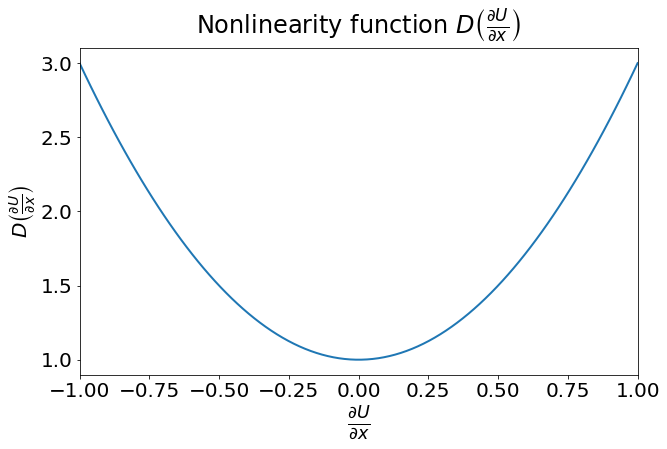

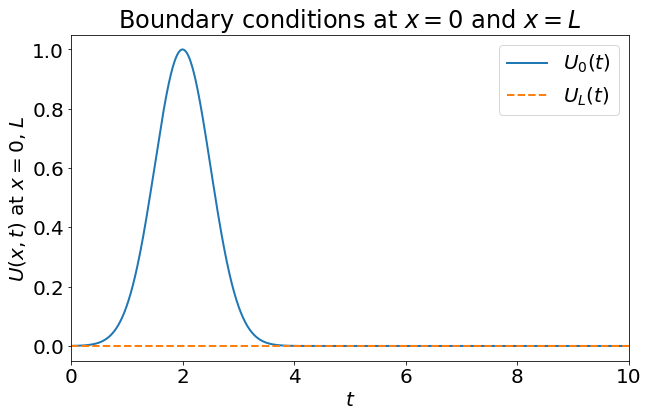

In [3]:
# Define nonlinearity and boundary functions
D = lambda dU_dx: 1 + 2*dU_dx**2
U0 = lambda t: 1.*np.exp(-2*(t-2)**2)
UL = lambda t: 0.


# Plot nonlinearity function D
dU_dx = np.linspace(-1,1,num=100)
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title(r'Nonlinearity function $D\left(\frac{\partial U}{\partial x}\right)$',
            y=1.03)
ax.plot(dU_dx,D(dU_dx),
        lw=2)
ax.set_xlabel(r'$\frac{\partial U}{\partial x}$',fontsize=25)
ax.set_ylabel(r'$D\left(\frac{\partial U}{\partial x}\right)$')
ax.set_xlim(np.min(dU_dx),np.max(dU_dx))
plt.show()
plt.close(fig)


# Plot boundary conditions at x = 0 and x = L
t = np.linspace(0,T,num=Nt,endpoint=True)
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title(r'Boundary conditions at $x=0$ and $x=L$')
ax.plot(t,U0(t),label=r'$U_0(t)$',lw=2)
ax.plot(t,np.vectorize(UL)(t),label=r'$U_L(t)$',ls='--',lw=2)
ax.legend(loc='best')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$U(x,t)$ at $x=0$, $L$')
ax.set_xlim(np.min(t),np.max(t))
plt.show()
plt.close(fig)

## 2. Simulation of the nonlinear fractional wave equation and illustration of the results

### Run simulation

In [4]:
import fractional_wave_equation as fwe

In [5]:
# create instance of class which contains the integrator for nonliner fractional wave equations
nonlinear_equation = fwe.numerical.nonlinear(parameters)

In [6]:
# run simulation with previously defined nonlinearity and boundary conditions
results = nonlinear_equation.simulate(D=D,
                            U0=U0,
                            UL=UL)

Running simulation. Progress: 100%, elapsed time: 0:00:50, remaining time: 0:00:00			


### 2D plot of the solution $U(x,t)$

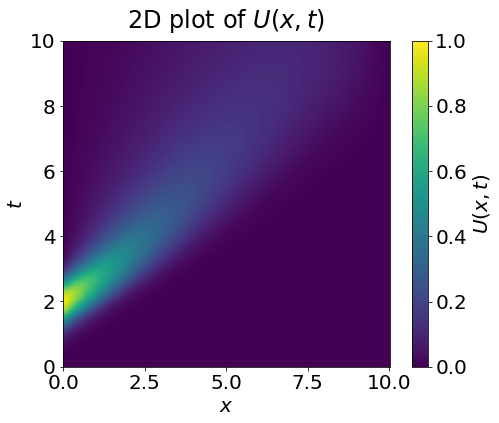

In [7]:
def plot_solution(results,title=None,filename=None):
    x, t, y = results['x'], results['t'], results['y']
    fig, ax = plt.subplots(1,1,figsize=(8, 6))
    if title != None:
        ax.set_title(title,y=1.02)
    c = ax.pcolormesh(x,t,y,
                      shading='auto',
                 )
    fig.colorbar(c,ax=ax,label=r'$U(x,t)$')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$t$')
    ax.set_aspect('equal')
    plt.show()
    if filename != None:
        fig.savefig(filename,bbox_inches='tight')
    plt.close(fig)
    
    
plot_solution(results,title=r'2D plot of $U(x,t)$',filename='nonlinear_solution_2D_plot.jpg')

In the above plot we nicely see that at $x = 0$ the boundary condition $U_0(t)$ leads to a rather defined shape for $U(x=0,t)$, which spreads out as $x$ is increased. This is reminiscent of diffusive behavior, see also point 3 below.

The further away from $x = 0$ one moves, the larger $t$ needs to be to see values of $U(x,t)$ which are significantly larger than $0$. This means that there is some finite speed at which the disturbance at $x = 0$ travels.

### Plots of the solution $U(x,t)$ as a function of $x$ at fixed times $t$

Note that for t = 0 we see the initial condition U(x,t=0) = 0


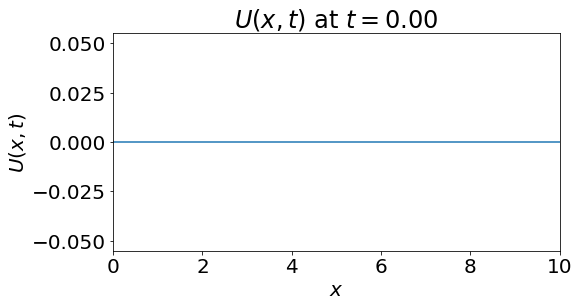

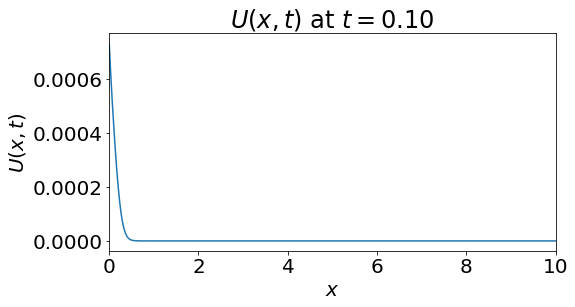

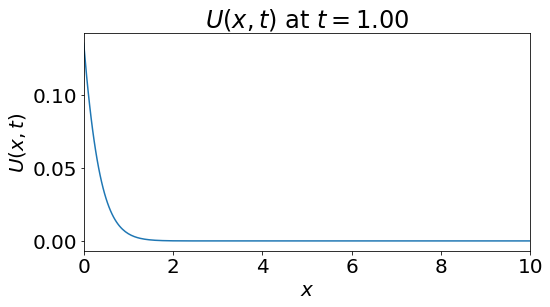

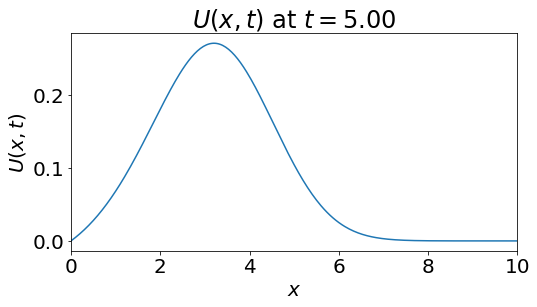

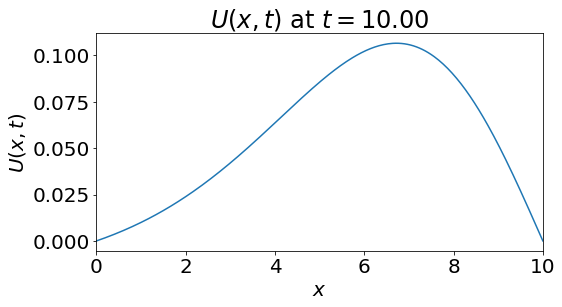

In [8]:
def plot_U_at_fixed_time(time,results,
                         x_range=None):
    '''
    Plots the solution U(x,t) as a function of x at a given time t
    '''
    t = results['t']
    x = results['x']
    y = results['y']
    # find index of closest time in simulation results
    plot_index = np.argmin( np.fabs( t - time ) )
    #
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    ax.set_title('$U(x,t)$ at $t = ${0:3.2f}'.format(t[plot_index]))
    ax.plot(x,y[plot_index])
    if x_range != None:
        ax.set_xlim(x_range)
    else:
        ax.set_xlim(np.min(x),np.max(x))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$U(x,t)$')
    plt.show()
    plt.close(fig)

    
plot_times = [0,0.1,1,5,10]
print("Note that for t = 0 we see the initial condition U(x,t=0) = 0")
for time in plot_times:
    plot_U_at_fixed_time(time=time,results=results)

### Plots of the solution $U(x,t)$ as a function of $t$ at fixed positions $x$

Note that at x = 0 and x = 10 we see the boundary conditions


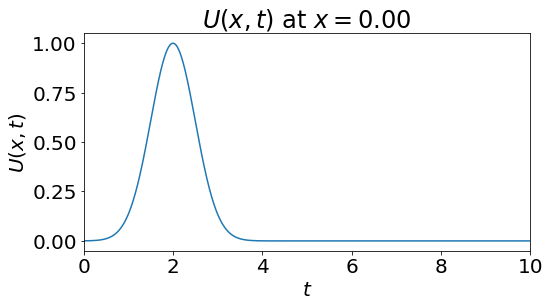

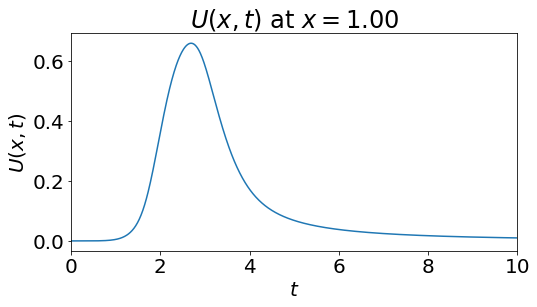

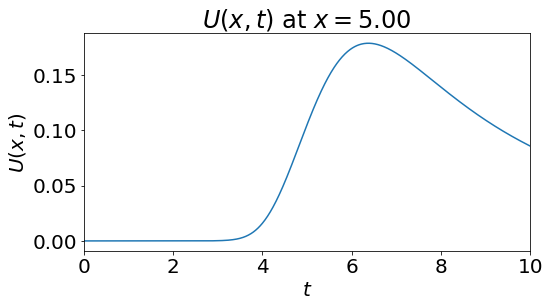

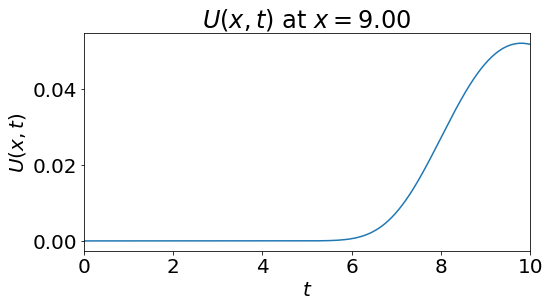

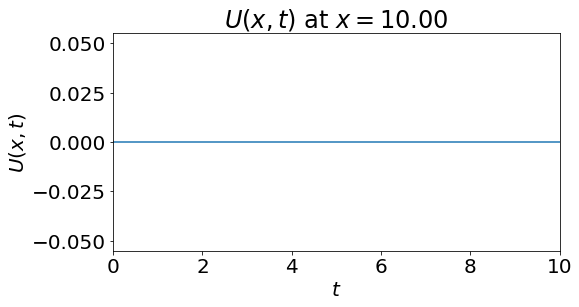

In [9]:
def plot_U_at_fixed_position(position,results,
                         t_range=None):
    '''
    Plots the solution U(x,t) as a function of t at a given position x
    '''
    t = results['t']
    x = results['x']
    y = results['y']
    # find index of closest position in simulation results
    plot_index = np.argmin( np.fabs( x - position ) )
    #
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    ax.set_title('$U(x,t)$ at $x = ${0:3.2f}'.format(x[plot_index]))
    ax.plot(t,y[:,plot_index])
    if t_range != None:
        ax.set_xlim(t_range)
    else:
        ax.set_xlim(np.min(t),np.max(t))
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$U(x,t)$')
    plt.show()
    plt.close(fig)

x_plot = [0,1,5,9,10]
print('Note that at x = 0 and x = 10 we see the boundary conditions')
for position in x_plot:
    plot_U_at_fixed_position(position=position,results=results)

### 2D plot of the local gradient $\partial_x U$

The local gradient $\partial_x U$ enters in the nonlinearity. We first plot $\partial_x U$, and then the function $D(\partial_x U)$ that defines the nonlinearity.

In [10]:
# calculate dU/dx
dx = results['dx']
t = results['t']
x = results['x']
y = results['y']

dU_dx = np.zeros_like(y)
dU_dx[:,1:-1] = ( y[:,2:] - y[:,:-2] ) / (2*dx)
dU_dx[:, 0] = ( y[:,1]  - y[:,0]   ) / dx
dU_dx[:,-1] = ( y[:,-1]  - y[:,-2]   ) / dx

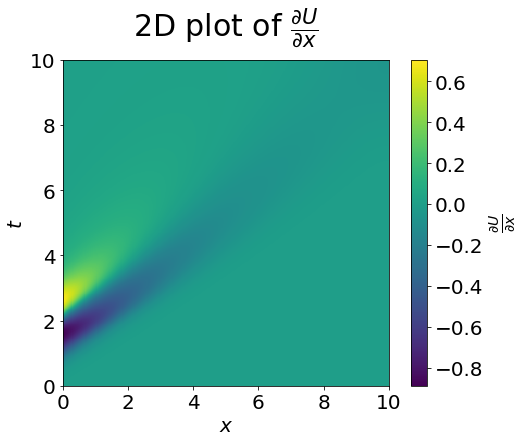

In [11]:
# Plot dU/dx
fig, ax = plt.subplots(1,1,figsize=(8, 6))
ax.set_title(r'2D plot of $\frac{\partial U}{\partial x}}$',
             y=1.05,fontsize=30)
c = ax.pcolormesh(x, t,dU_dx,
                  shading='auto',
             )
ax.set_xlim(np.min(x),np.max(x))
ax.set_ylim(np.min(t),np.max(t))
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
fig.colorbar(c,ax=ax,
             label=r'$\frac{\partial U}{\partial x}$')
plt.show()
plt.close(fig)

As expected, the values where $\partial_x U$ is noticably nonzero are close to where $U(x,t)$ was seen to be nonzero in the previous 2D plot of $U$.

### Plots of the gradient $\partial_x U(x,t)$ as a function of $t$ at fixed positions $x$

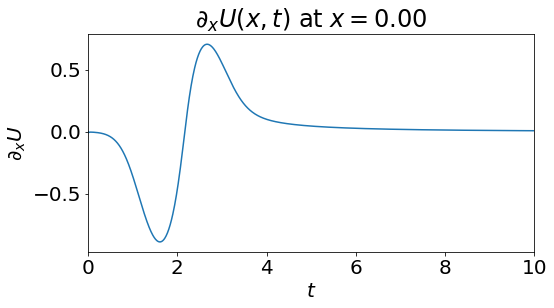

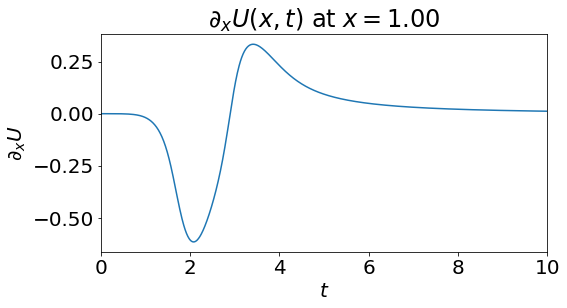

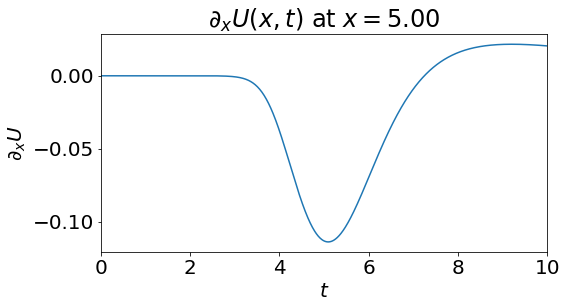

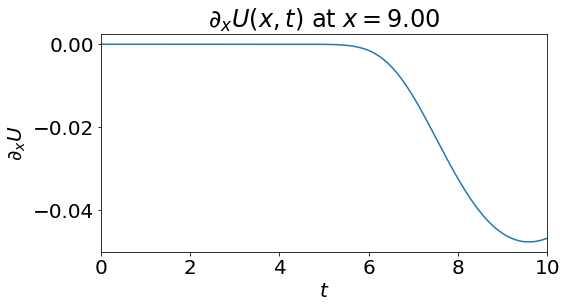

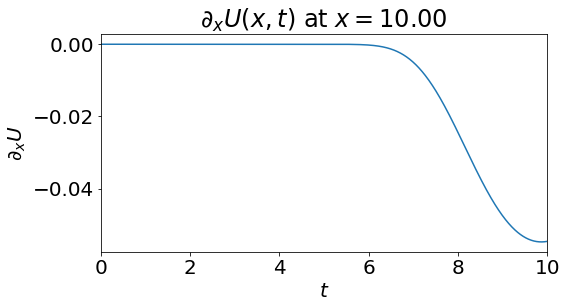

In [12]:
def plot_dU_dx_at_fixed_position(position,results,
                         t_range=None):
    '''
    Plots the gradient dU/dx(x,t) as a function of t at a given position x
    '''
    x, y, t, dx = results['x'], results['y'], results['t'], results['dx']
    # find index of closest time in simulation results
    plot_index = np.argmin( np.fabs( x - position ) )
    #
    if (plot_index == 0):
        y_plot = ( y[:,plot_index+1] - y[:,plot_index] ) / dx
    elif (plot_index == len(x)-1):
        y_plot = ( y[:,-1] - y[:,-2] ) / dx
    else:
        y_plot = ( y[:,plot_index+1] - y[:,plot_index-1] ) / (2*dx)
    #
    #
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    ax.set_title('$\partial_x U(x,t)$ at $x = ${0:3.2f}'.format(x[plot_index]))
    ax.plot(t,y_plot)
    if t_range != None:
        ax.set_xlim(t_range)
    else:
        ax.set_xlim(np.min(t),np.max(t))
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$\partial_x U$')
    plt.show()
    plt.close(fig)
    
    
x_plot = [0,1,5,9,10]
for position in x_plot:
    plot_dU_dx_at_fixed_position(position=position,results=results)

### Plot of the nonlinearity $D(\partial_x U)$

Plotting $D(\partial_x U)$ is a simple way to assess the relevance of the nonlinearity in the fractional wave equation.

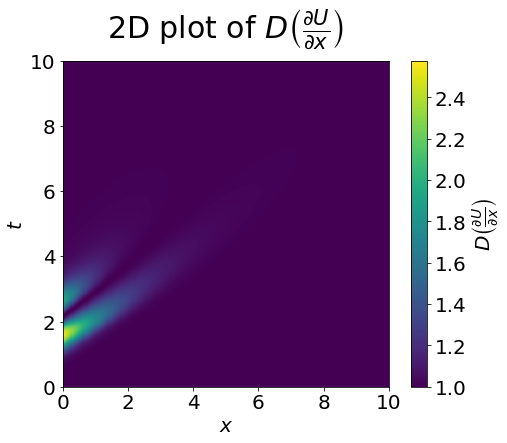

In [13]:
# Plot D( dU/dx )
fig, ax = plt.subplots(1,1,figsize=(8, 6))
ax.set_title(r'2D plot of $D\left(\frac{\partial U}{\partial x}\right)$',
             y=1.05,fontsize=30)
c = ax.pcolormesh(results['x'], results['t'], D(dU_dx),
                  shading='auto',
             )
ax.set_xlim(np.min(x),np.max(x))
ax.set_ylim(np.min(t),np.max(t))
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
fig.colorbar(c,ax=ax,
             label=r'$D\left( \frac{\partial U}{\partial x}\right)$')
plt.show()
plt.close(fig)

From this plot we see that nonlinear effects seem relevant for times $t \lesssim 5$ and positions $x \lesssim 5$. For $t > 5$ or $x > 5$, the plot indicates that $D(\partial_x U) \approx 1$. 

The deviation of $D(\partial_x U)$ from $1$ could of course be checked with much higher sensititivty by plotting $\ln\left[ D(\partial_x U) - 1\right]$.

## 3. Comparison of simulation results for various values of $\alpha$

The fractional wave equation 

\begin{equation}
\boxed{
\frac{\partial^{\alpha} U}{\partial t^{\alpha}} = D(\partial_x U) \frac{\partial^2 U}{\partial x^2},
}
\end{equation}

with $\alpha \in (0,1)$ interpolates between a (nonlinear) diffusion equation, $\alpha = 1$, and a (nonlinear) wave equation, $\alpha = 2$.

To illustrate this we now compare the solution of the fractional wave equation for $\alpha = 1.01$, $\alpha = 1.5$, and $\alpha = 1.99$.

In [14]:
# To run a nonliear simulation with different parameters, we can either create a new instance 
# of the class "nonlinear", or change the parameters of our already existing instance.
# We do the latter here.

# first print the current parameters, which we used for the simulations above
print("Before changing parameter:")
nonlinear_equation.get_parameters(print_parameters=True);

# set new parameter in existing class instance
new_parameter = {'alpha':1.01}
nonlinear_equation.set_parameters(new_parameter)

# print new parameters of class instance
print("\nAfter changing parameter:")
nonlinear_equation.get_parameters(print_parameters=True);

Before changing parameter:
Parameters set for this instance:
L       = 10
Nx      = 299
T       = 10.0
Nt      = 1000
alpha   = 1.5
verbose = True

After changing parameter:
Parameters set for this instance:
L       = 10
Nx      = 299
T       = 10.0
Nt      = 1000
alpha   = 1.01
verbose = True


In [15]:
# run simulation alpha = 1.01, and all other parameters as before
results_1 = nonlinear_equation.simulate(D=D,
                            U0=U0,
                            UL=UL)

Running simulation. Progress: 100%, elapsed time: 0:00:50, remaining time: 0:00:00			


In [16]:
# run simulation alpha = 1.99, and all other parameters as before
new_parameter = {'alpha':1.99}
nonlinear_equation.set_parameters(new_parameter)

results_2 = nonlinear_equation.simulate(D=D,
                            U0=U0,
                            UL=UL)

Running simulation. Progress: 100%, elapsed time: 0:00:47, remaining time: 0:00:00			


### 2D plot of the solution $U(x,t)$

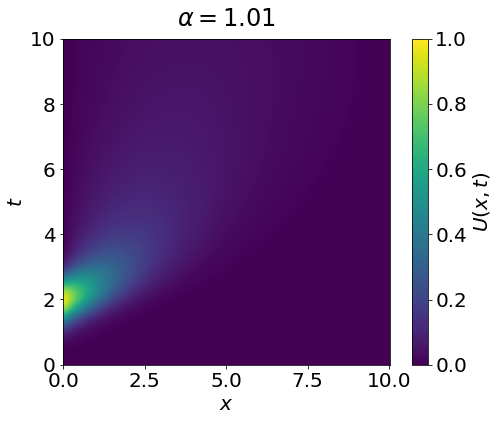

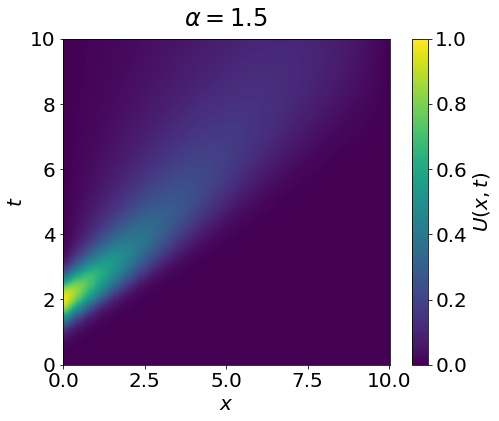

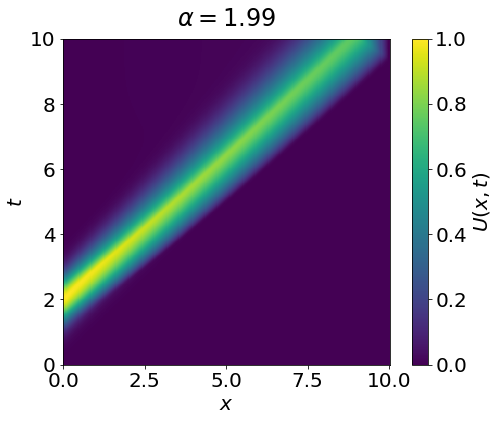

In [17]:
plot_solution(results_1,title=r'$\alpha = 1.01$')
plot_solution(results,title=r'$\alpha = 1.5$')
plot_solution(results_2,title=r'$\alpha = 1.99$')

The three plots illustrate how the fractional wave equation interpolates between diffusive and wave-like behavior:

* For $\alpha = 1.01$ we observe that the initial condition disperses rather quickly. 
* While for $\alpha = 1.5$ we also observe that the initial condition disperses, the solution exists longer and propagates a bit further as compared to $\alpha = 1.01$ before it has dispersed.
* For $\alpha = 1.99$ we observe very little dispersion. The initial condition propagates almost dispersion-free with a constant speed $c \approx 1$. Close to $x = 10$ we start seeing boundary effects from the boundary condition $U_L(t) = 0$.